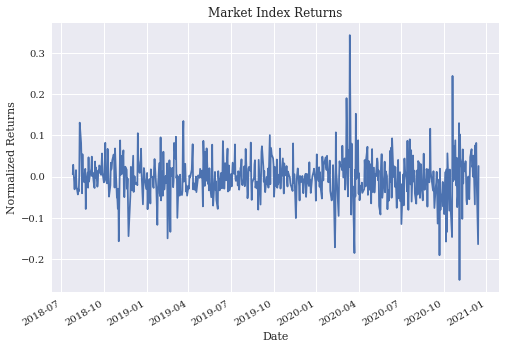

In [1]:
# Portfolio Tearsheet

%matplotlib inline
import numpy as np
import pandas as pd
from pylab import mpl, plt
import math
import os
import sys
import scipy.optimize as sco
from tabulate import tabulate

plt.style.use('seaborn')
mpl.rcParams['font.family']='serif'

data=pd.read_csv('./portfolio.csv', index_col=0, parse_dates=True)

rets = np.log(data/data.shift(1))  # normalized returns  
rets = rets.dropna()

#rets.iloc[:,0].plot(ylabel='Normalized Returns', title='Market Index Returns')
#plt.savefig('1-market_plot.png')
#plt.show()

# save text results to file
#with open('1-portfolioTearSheet.txt','w') as f:
#    print('Market Index Returns:', file=f)
#    print(rets.iloc[:,0].to_markdown(), file=f)
#    print('', file=f)

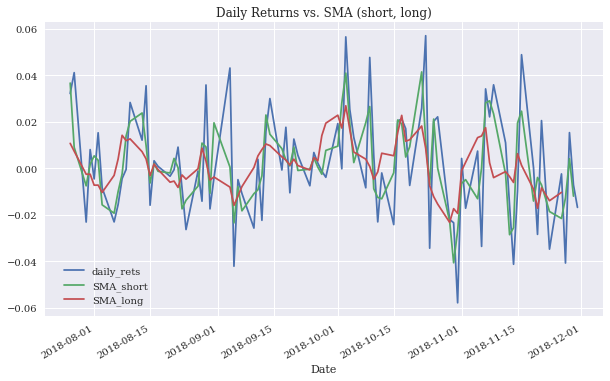

In [4]:
# select portfolio stock data
port = rets.iloc[-90:,[0,2,3,4,5,6,7,8]]

# number of assets
noa = len(port.columns)

# portfolio returns, volatility, and function to minimize
def port_ret(weights):
    return np.sum(port.mean()*weights)*252 # 252 trading days

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(port.cov()*252, weights)))

def min_func_sharpe(weights):
    return -port_ret(weights)/port_vol(weights)

eweights = np.array(noa*[1./noa,]) # equally weighted, total = 100%

daily_rets = port.mean(axis=1)

# convert series to dataframe
frame = {'daily_rets':daily_rets}
df = pd.DataFrame(frame)

# window lengths for simple moving averages
short = 2
long = 5

df1 = pd.DataFrame(df['daily_rets'])
df1['SMA_short'] = df['daily_rets'].rolling(window=short).mean()
df1['SMA_long'] = df['daily_rets'].rolling(window=long).mean()

#df1['positions'] = np.where(df1['SMA_short'] > df1['SMA_long'], 1, -1)

ax = df1[['daily_rets', 'SMA_short', 'SMA_long']].plot(figsize=(10,6), title='Daily Returns vs. SMA (short, long)')
plt.savefig('2-dailyVsSMA.png')
ax.get_legend().set_bbox_to_anchor((0.2, 0.2));

# save text results to file
with open('2-portfolioTearSheet.txt','w') as f:
    print('Portfolio:', file=f)
    #print(tabulate(port[:10], headers='keys', tablefmt='psql'), file=f)
    print(port[:10].to_markdown(), file=f)
    print('', file=f)
    print('Portfolio statistics:', file=f)
    print('', file=f)
    print('annualized return:    ', port_ret(eweights).round(3), file=f)
    print('annualized volatiliy: ', port_vol(eweights).round(3), file=f)
    print('Sharpe ratio:         ', -min_func_sharpe(eweights).round(3), file=f)
    print('', file=f)

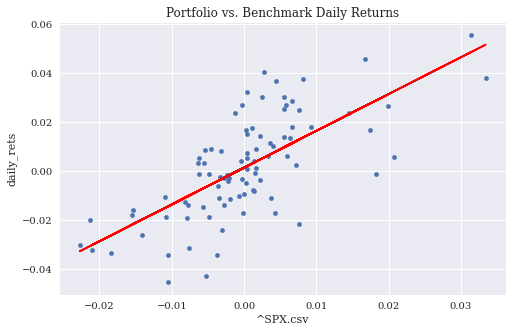

Beta:    1.506
Alpha:  0.001


In [10]:
# get index data
data = pd.DataFrame(rets.iloc[-90:,1])

# get portfolio daily returns
data['daily_rets'] = df1['daily_rets']

data.plot(kind='scatter', x='^SPX.csv', y='daily_rets', figsize=(8,5), grid=True, \
        title='Portfolio vs. Benchmark Daily Returns')

beta_PORT, alpha_PORT = np.polyfit(data['^SPX.csv'], df['daily_rets'],1) # regression fit line to portfolio returns
    
plt.plot(data['^SPX.csv'], beta_PORT*data['^SPX.csv']+alpha_PORT, '-', color='r') # plot regression line
plt.savefig('3-portfolioVsBenchmark.png')
plt.show() # show plot

# save text results to file
with open('3-portfolioTearSheet.txt','w') as f:
    print('Portfolio:', file=f)
    print('Beta:   ', beta_PORT.round(3), file=f)
    print('Alpha: ', alpha_PORT.round(3), file=f)
    print('', file=f)

# display to screen
print('Beta:   ', beta_PORT.round(3))
print('Alpha: ', alpha_PORT.round(3))

In [15]:
# setup optimizer
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    
bnds = tuple((0,1) for x in range(noa))
    
opts = sco.minimize(min_func_sharpe, eweights, method="SLSQP", bounds=bnds, constraints=cons)

# optimized porfolio statistics

# print to file
with open('4-portfolioTearSheet.txt','w') as f:
    print('Optimized Portfolio:', file=f)
    print('', file=f)
    df2 = pd.DataFrame(opts['x'].round(3), port.columns.values)
    df2 = df2.rename(columns={0:'Weights'})
    print(df2, file=f)
    print('', file=f)
    print('Estimated results:', file=f)
    #print('annualized return:     ', port_ret(opts['x']).round(3), file=f)
    #print('annualized volatility: ',port_vol(opts['x']).round(3), file=f)
    print('', file=f)
    sharpe = port_ret(opts['x'])/port_vol(opts['x'])
    print('Sharpe ratio:   ', sharpe.round(3), file=f)

# display to screen
print('Optimized Portfolio:')
print('')
df2 = pd.DataFrame(opts['x'].round(3), port.columns.values)
df2 = df2.rename(columns={0:'Weights'})
print(df2)
print('')
print('Estimated results:')
#print('annualized return:     ', port_ret(opts['x']).round(3))
#print('annualized volatility: ',port_vol(opts['x']).round(3))
print('')
sharpe = port_ret(opts['x'])/port_vol(opts['x'])
print('Sharpe ratio:   ', sharpe.round(3))

Optimized Portfolio:

          Weights
PDD.csv     0.000
GNRC.csv    0.000
JD.csv      0.624
IDXX.csv    0.376
CUB.csv     0.000
CPRT.csv    0.000

Estimated results:

Sharpe ratio:    2.615
